In [1]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from tqdm import tqdm

from torch.nn import functional as F
from collections import OrderedDict
import math
device = "cuda"

# load model and data

In [2]:
Data_00=np.load("results2022/01x40_padded.npy",allow_pickle=True)
Data_01Nami=np.load("results2022/02x40_padded.npy",allow_pickle=True)

print("Data_00.shape:", Data_00.shape)
print("Data_01Nami.shape:", Data_01Nami.shape)

Data_00.shape: (65969, 100, 100, 3)
Data_01Nami.shape: (3219, 100, 100, 3)


# define class function

In [3]:
# 定义钩子函数，获取指定层名称的特征
feature_activation = {} # 保存获取的输出
def get_activation(name):
    def hook(model, input, output):
        feature_activation[name] = output.detach()
    return hook

In [4]:
class OriginIMG:
    def __init__(self,img):
        self.img = img
        self.shape = img.shape

    def pad(self,Max_shape_0,Max_shape_1):
        self.top,self.bottom = (Max_shape_0-self.shape[0])//2,(Max_shape_0-self.shape[0])//2
        self.left,self.right = (Max_shape_1-self.shape[1])//2,(Max_shape_1-self.shape[1])//2
        if (self.shape[0] % 2) != 0:
            self.top,self.bottom = (Max_shape_0-self.shape[0])//2,(Max_shape_0-self.shape[0])//2+1
        if (self.shape[1] % 2) != 0:     
            self.left,self.right = (Max_shape_1-self.shape[1])//2,(Max_shape_1-self.shape[1])//2+1
        imgpad = cv2.copyMakeBorder(self.img,self.top,self.bottom,self.left,self.right,
                                    cv2.BORDER_CONSTANT,value=(0,0,0))
        return imgpad

    def bin_ndarray(self,new_shape,operation):
        operation = operation.lower()
        if not operation in ['sum', 'mean']:
            raise ValueError("Operation not supported.")
        if self.img.ndim != len(new_shape):
            raise ValueError("Shape mismatch: {} -> {}".format(self.shape,new_shape))
        compression_pairs = [(d, c//d) for d,c in zip(new_shape,self.shape)]
        flattened = [l for p in compression_pairs for l in p]
        imgresize = self.img.reshape(flattened)
        for i in range(len(new_shape)):
            op = getattr(imgresize, operation)
            imgresize = op(-1*(i+1))
        return imgresize
    
    def predict(self,model,input_img,label):
        transform = transforms.Compose([transforms.ToTensor()])
        input_tensor = transform(input_img).unsqueeze(0).to(device)
        output = model(input_tensor)
        y = output.argmax(1).cpu().item()
        return y==label, y
        
    def plot_feature(self,model,input_img,target_layer):
        for name, layer in model.named_modules():
            layer.register_forward_hook(get_activation(name))
        transform = transforms.Compose([transforms.ToTensor()])
        input_tensor = transform(input_img).unsqueeze(0).to(device)
        output = model(input_tensor)
        # plot each layer result
        for key in [target_layer]:
            bn = feature_activation[key].cpu()
            print(key," : ",bn.shape)
            s = int(input_img.shape[0]/bn.shape[2])
            n = math.ceil(math.sqrt(bn.shape[1]))
            plt.figure(figsize=(20,20))
            for i in range(bn.shape[1]):
                plt.subplot(n,n,i+1)
#                 plt.imshow(bn[0,i,:,:], cmap='gray')
                plt.imshow(bn[0,i,int(self.top/s):int((self.top+self.shape[0])/s),
                                  int(self.left/s):int((self.left+self.shape[1])/s)], cmap='gray')
            plt.show()

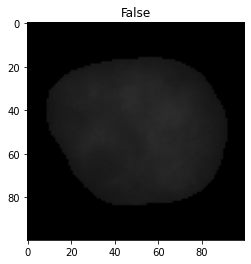

layer1.1.conv1  :  torch.Size([1, 64, 25, 25])


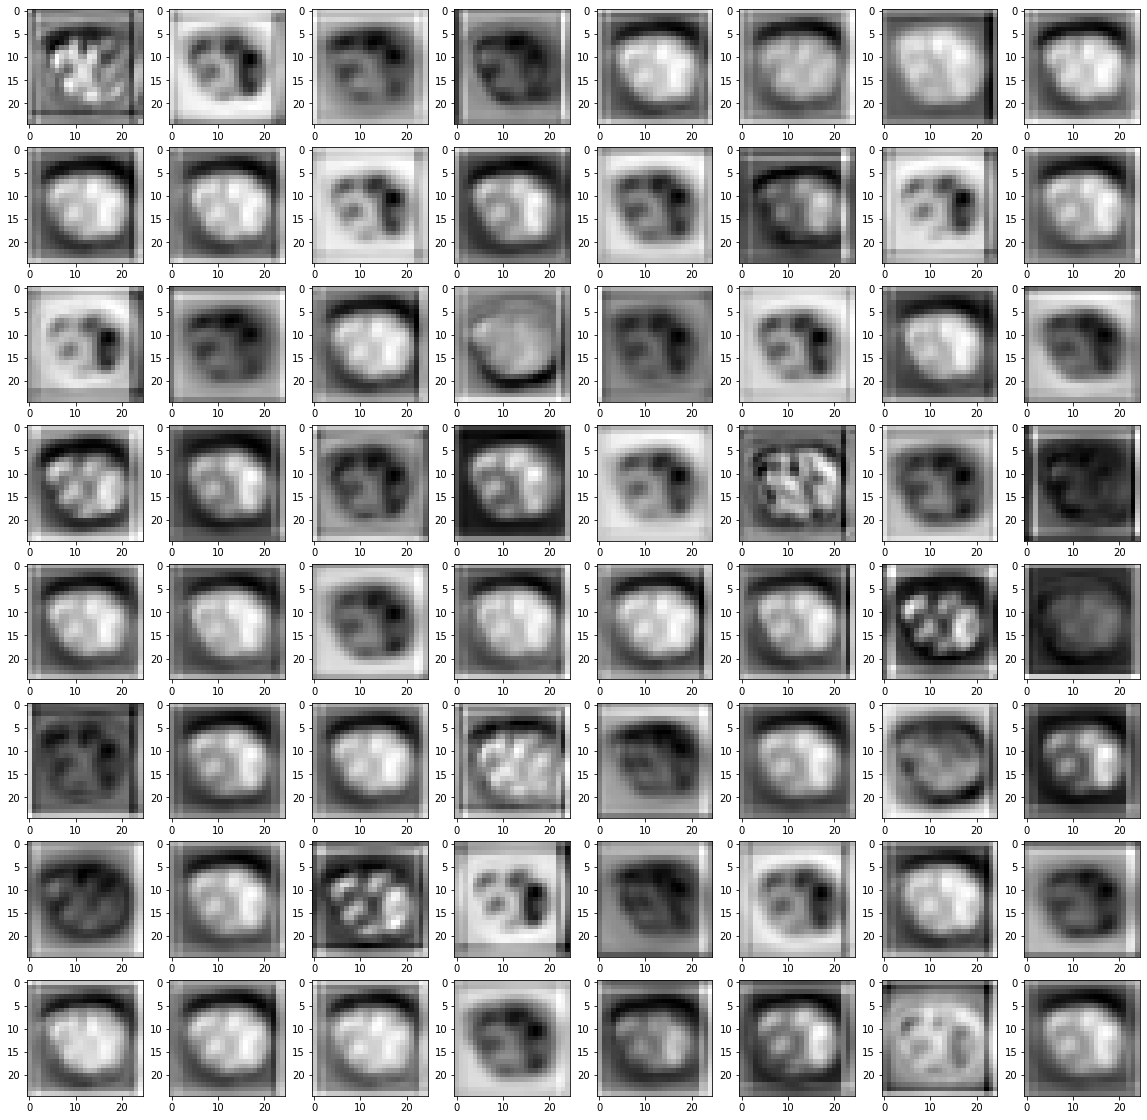

In [9]:
# load model
PATH = "SelfResnet18_L2F1_200.pkl"
model = torch.load(PATH)
label = [0]
# check predict label correct or not
for i in range(1):
    # pad 
    img = OriginIMG(Data_01Nami[1])
    imgpad = img.pad(100,100)
    # predict
    tf, pred = img.predict(model,imgpad,label[i])
    plt.title(tf)
    plt.imshow(imgpad)
    plt.show()
    # plot feature
    target_layer = "layer1.1.conv1"
    img.plot_feature(model,imgpad,target_layer)

In [7]:
for key in feature_activation:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)

conv1  :  torch.Size([1, 64, 50, 50])
bn1  :  torch.Size([1, 64, 50, 50])
relu  :  torch.Size([1, 64, 50, 50])
maxpool  :  torch.Size([1, 64, 25, 25])
layer1.0.conv1  :  torch.Size([1, 64, 25, 25])
layer1.0.bn1  :  torch.Size([1, 64, 25, 25])
layer1.0.relu  :  torch.Size([1, 64, 25, 25])
layer1.0.conv2  :  torch.Size([1, 64, 25, 25])
layer1.0.bn2  :  torch.Size([1, 64, 25, 25])
layer1.0  :  torch.Size([1, 64, 25, 25])
layer1.1.conv1  :  torch.Size([1, 64, 25, 25])
layer1.1.bn1  :  torch.Size([1, 64, 25, 25])
layer1.1.relu  :  torch.Size([1, 64, 25, 25])
layer1.1.conv2  :  torch.Size([1, 64, 25, 25])
layer1.1.bn2  :  torch.Size([1, 64, 25, 25])
layer1.1  :  torch.Size([1, 64, 25, 25])
layer1  :  torch.Size([1, 64, 25, 25])
layer2.0.conv1  :  torch.Size([1, 128, 13, 13])
layer2.0.bn1  :  torch.Size([1, 128, 13, 13])
layer2.0.relu  :  torch.Size([1, 128, 13, 13])
layer2.0.conv2  :  torch.Size([1, 128, 13, 13])
layer2.0.bn2  :  torch.Size([1, 128, 13, 13])
layer2.0.downsample.0  :  torch.S